In [36]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from scipy.stats import chi2_contingency
from scipy.stats import pointbiserialr
import scipy.stats as stats
import numpy as np
import pandas as pd
import ipywidgets as widgets
import matplotlib.pyplot as plt
from ipywidgets import *

In [3]:
loc = '/Users/arjun17/Downloads/insurance.csv'

In [4]:
df = pd.read_csv(loc)

In [5]:
df_orig = pd.read_csv(loc)

In [6]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [7]:
encoder = LabelEncoder()

In [8]:
df['sex'] = encoder.fit_transform(df['sex'])
df['smoker'] = encoder.fit_transform(df['smoker'])

region_dummies = pd.get_dummies(df['region'], prefix='region', drop_first=True)
df = pd.concat([df, region_dummies], axis=1)
df.drop('region', axis=1, inplace=True)

In [9]:
df.head()

,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,1
1,18,1,33.770,1,0,1725.55230,0,1,0
2,28,1,33.000,3,0,4449.46200,0,1,0
3,33,1,22.705,0,0,21984.47061,1,0,0
4,32,1,28.880,0,0,3866.85520,1,0,0


In [11]:
df.dtypes

age                   int64
sex                   int64
bmi                 float64
children              int64
smoker                int64
charges             float64
region_northwest      uint8
region_southeast      uint8
region_southwest      uint8
dtype: object

In [15]:
@interact
def correlations(column1=df.columns, column2=df.columns):
    col1_dtype = df[column1].dtype
    col2_dtype = df[column2].dtype
    
    if (np.issubdtype(col1_dtype, np.number) and not np.issubdtype(col1_dtype, np.uint8)) and \
       (np.issubdtype(col2_dtype, np.number) and not np.issubdtype(col2_dtype, np.uint8)):
        print(f"Pearson's Correlation: {df[column1].corr(df[column2])}")
        
    elif (np.issubdtype(col1_dtype, np.number) and not np.issubdtype(col2_dtype, np.uint8)) or \
         (not np.issubdtype(col1_dtype, np.number) and np.issubdtype(col2_dtype, np.number)):
        categorical_col = column1 if not np.issubdtype(col1_dtype, np.number) else column2
        continuous_col = column1 if np.issubdtype(col1_dtype, np.number) else column2
        
        corr, p_val = pointbiserialr(df[categorical_col], df[continuous_col])
        print(f"Point-Biserial Correlation: {corr}")
        
    else:
        contingency_table = pd.crosstab(df[column1], df[column2])
        chi2, p, _, _ = chi2_contingency(contingency_table)
        
        print(f"Chi-squared Value: {chi2}")
        print(f"P-value: {p}")


interactive(children=(Dropdown(description='column1', options=('age', 'sex', 'bmi', 'children', 'smoker', 'cha…

In [16]:
continuous_features = ['age', 'bmi', 'children']
categorical_features = ['sex', 'smoker', 'region_northwest', 'region_southeast', 'region_southwest']

def anova_test(data, cat_col, target_col):
    categories = data[cat_col].unique()
    args = [data[target_col][data[cat_col] == category] for category in categories]
    f_stat, p_val = stats.f_oneway(*args)
    return f_stat, p_val

correlation_threshold = 0.1
correlations = df[continuous_features + ['charges']].corr()['charges'].abs().drop('charges')
selected_continuous_features = correlations[correlations > correlation_threshold].index.tolist()

print("Selected Continuous Features based on Correlation:\n", selected_continuous_features)

p_value_threshold = 0.05 
anova_results = {}
for feature in categorical_features:
    f_stat, p_val = anova_test(df, feature, 'charges')
    if p_val < p_value_threshold:
        anova_results[feature] = {'F-statistic': f_stat, 'p-value': p_val}

selected_categorical_features = list(anova_results.keys())

print("\nSelected Categorical Features based on ANOVA:\n", selected_categorical_features)

all_selected_features = selected_continuous_features + selected_categorical_features
print("\nAll Selected Features:\n", all_selected_features)


Selected Continuous Features based on Correlation:
 ['age', 'bmi']

Selected Categorical Features based on ANOVA:
 ['sex', 'smoker', 'region_southeast']

All Selected Features:
 ['age', 'bmi', 'sex', 'smoker', 'region_southeast']


In [18]:
X = df[all_selected_features]
X.head()

,age,bmi,sex,smoker,region_southeast
0,19,27.900,0,1,0
1,18,33.770,1,0,1
2,28,33.000,1,0,1
3,33,22.705,1,0,0
4,32,28.880,1,0,0


In [19]:
target = df['charges']

In [20]:
target.head()

0    16884.92400
1     1725.55230
2     4449.46200
3    21984.47061
4     3866.85520
Name: charges, dtype: float64

In [21]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, target, test_size = 0.2)

In [22]:
model = LinearRegression()

In [23]:
model.fit(Xtrain,Ytrain)

LinearRegression()

In [24]:
y_pred_training = model.predict(Xtest)
print("Training MAE:", mean_absolute_error(y_pred_training, Ytest))

Training MAE: 4256.1742134066835


In [58]:
def plot_with_regression(age, bmi, y_pred):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
    
    axes[0].scatter(X["age"], target, alpha=0.5, label='Data')
    axes[0].scatter(age, y_pred, color='red', label='Prediction')
    axes[0].plot([age, age], [0, y_pred], linestyle='--', color='red')
    axes[0].set_title("Scatter plot of Age vs. Insurance Cost with Regression Prediction")
    axes[0].set_xlabel("Age")
    axes[0].set_ylabel("Charges in $")
    axes[0].legend()
    axes[0].grid(True)
    
    axes[1].scatter(X["bmi"], target, alpha=0.5, label='Data')
    axes[1].scatter(bmi, y_pred, color='red', label='Prediction')
    axes[1].plot([bmi, bmi], [0, y_pred], linestyle='--', color='red')
    axes[1].set_title("Scatter plot of BMI vs. Insurance Cost with Regression Prediction")
    axes[1].set_xlabel("BMI")
    axes[1].set_ylabel("Charges in $")
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

In [59]:
def make_prediction(age, bmi, smoker, sex, region_southeast):
    df = pd.DataFrame({"age":age, 
                       "bmi":bmi, 
                       "sex":sex, 
                       "smoker":smoker, 
                       "region_southeast":region_southeast
                      },index=[0])
    prediction = model.predict(df).round(2)[0]
    plot_with_regression(age, bmi, prediction)
    return f"Predicted total insurance cost: ${prediction}"

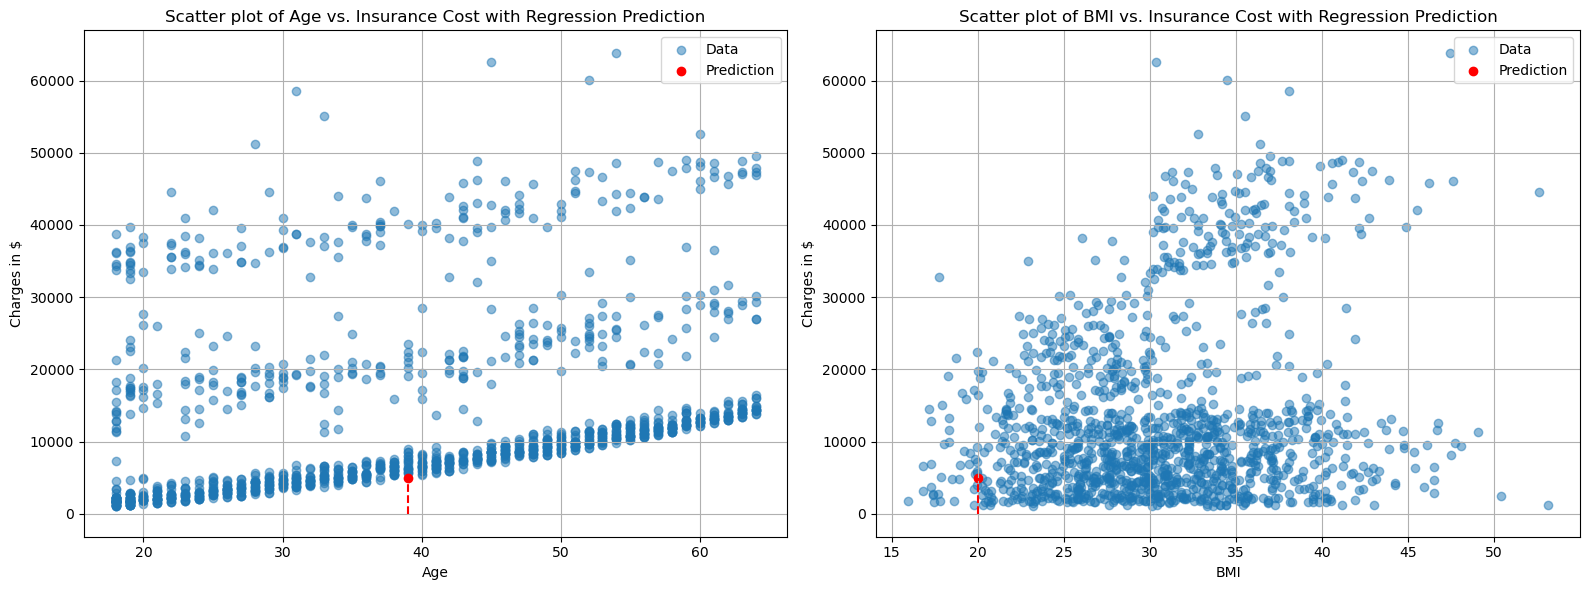

'Predicted total insurance cost: $4955.76'

In [60]:
make_prediction(39, 20, 0, 1, 0)

In [61]:
print("Smoker: \nYes = 1 \nNo = 0\n\n")
print("Sex: \nMale = 1 \nFemale = 0\n\n")
print("region_southeast: \nYes = 1 \nNo = 0\n\n")

widgets.interact(
                make_prediction,
    
                age=IntSlider(
                    min=X["age"].min(),
                    max=X["age"].max(),
                    value=X["age"].mean(),
                ),
                bmi= widgets.FloatSlider(
                    min=X["bmi"].min(),
                    max=X["bmi"].max(),
                    step=0.01,
                    value=X["bmi"].mean(),
                ),
                smoker = widgets.Dropdown(options=sorted(X["smoker"].unique())),
                sex = widgets.Dropdown(options=sorted(X["sex"].unique())), 
                region_southeast = widgets.Dropdown(options=sorted(X["region_southeast"].unique())), 
            );

Smoker: 
Yes = 1 
No = 0


Sex: 
Male = 1 
Female = 0


region_southeast: 
Yes = 1 
No = 0




interactive(children=(IntSlider(value=39, description='age', max=64, min=18), FloatSlider(value=30.66339686098…